Project FILIÈRE RECHERCHE

Under the supervision of :

Elisabeth Lahalle

Students :

- Ricardo Chiquetto do Lago
- Maxsuel Fernandes de Almeida
- Samara Ndiaye
- Ana Cecilia Reghini
- Lucas Tramonte

# Libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from scipy.ndimage import binary_dilation, binary_closing
import json

# Data

In [2]:
data_gamma_irradiation = pd.read_csv("Assets/Data/2015_months_DebitDoseA.csv")
data_hygometry = pd.read_csv("Assets/Data/2015_months_HYGR.csv")
data_patm = pd.read_csv("Assets/Data//2015_months_PATM.csv")
data_temp = pd.read_csv("Assets//Data//2015_months_TEMP.csv")

In [3]:
#data_gamma_irradiation

# Data Visualization

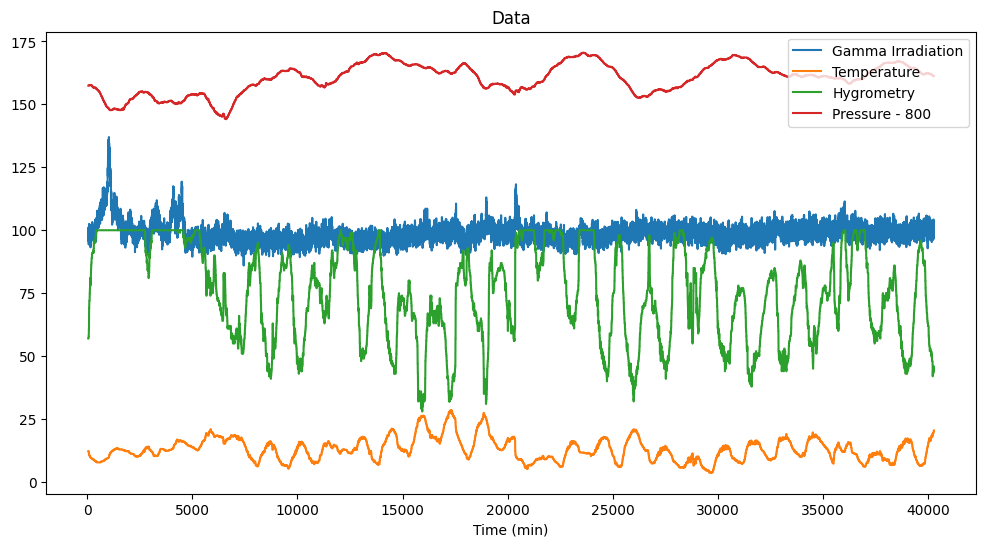

In [4]:
# Define the month (1: February, 2: April, 3: June, 4: October)
month = 2 # selected month: June

# Extract data for the selected month
sigg = data_gamma_irradiation.iloc[:, month-1]  # Gamma irradiation data
sigt = data_temp.iloc[:, month-1]               # Temperature data
sigh = data_hygometry.iloc[:, month-1]          # Hygrometry data
sigp = data_patm.iloc[:, month-1]               # Atmospheric pressure data

# Remove the first and last hour of data
N = len(sigg)  # number of data points
fe = 1/60      # sampling frequency
t = np.array(range(N))  # time vector

Nh = 60  # 1 hour
t_trimmed = t[Nh:N-Nh]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_trimmed, sigg[Nh:N-Nh], label='Gamma Irradiation')
plt.plot(t_trimmed, sigt[Nh:N-Nh], label='Temperature')
plt.plot(t_trimmed, sigh[Nh:N-Nh], label='Hygrometry')
plt.plot(t_trimmed, sigp[Nh:N-Nh] - 800, label='Pressure - 800')

plt.xlabel('Time (min)')
plt.title('Data')
plt.legend()
plt.show()


## Ploting the 5 months

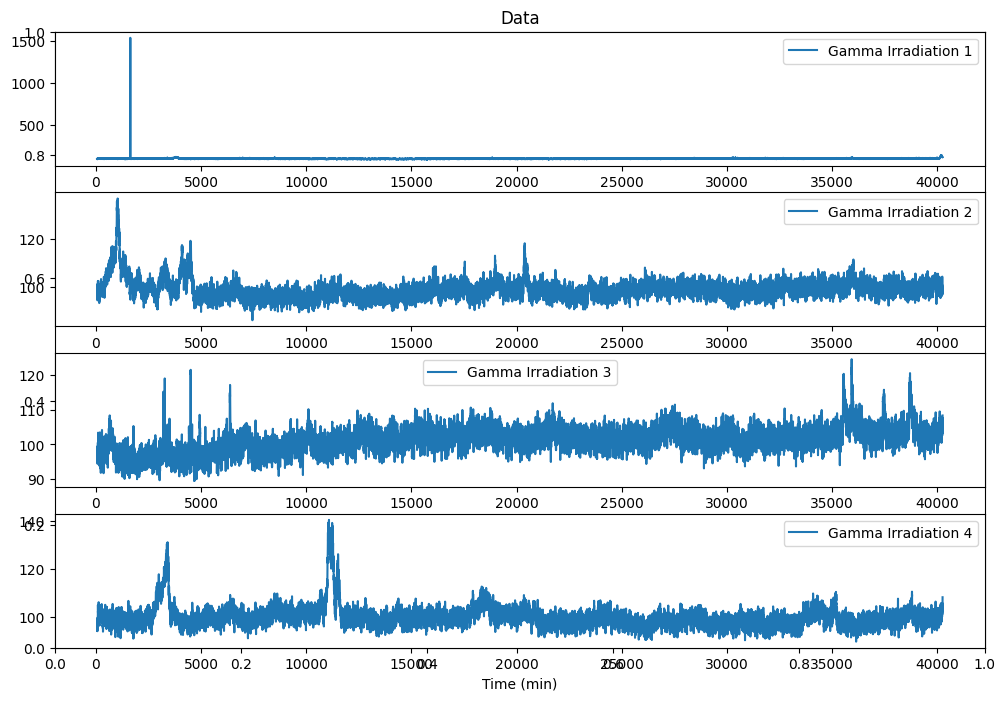

In [5]:
plt.figure(figsize=(12, 8))
plt.title('Data')

for i in range(4):
    plt.subplot(4, 1, i+1)

    # Remove the first and last hour of data
    Nh = 60  # 1 hour
    t_trimmed = t[Nh:N-Nh]

    # Plot the data
    plt.plot(t_trimmed, data_gamma_irradiation.iloc[:, i][Nh:N-Nh], label=f'Gamma Irradiation {i+1}')
    plt.legend()
    
plt.xlabel('Time (min)')


plt.show()


## Outlier removing

In [6]:
# Define a structuring element (for example, a window of size 3)
structure = np.ones(5)  # A window of size 3 will dilate 'True' values to neighboring points

# replace all values above 1000 with the average of the two surrounding values
def remove_outliers(s, threshold=800):
    s = s.copy()
    idx = s > threshold
    # Apply binary dilation
    expanded_series = binary_dilation(idx, structure=structure)
    mu = s.mean()
    s[expanded_series] = mu
    return s

In [7]:
filtered_data = data_gamma_irradiation.copy()
filtered_data.iloc[:, 0] = remove_outliers(data_gamma_irradiation.iloc[:, 0])

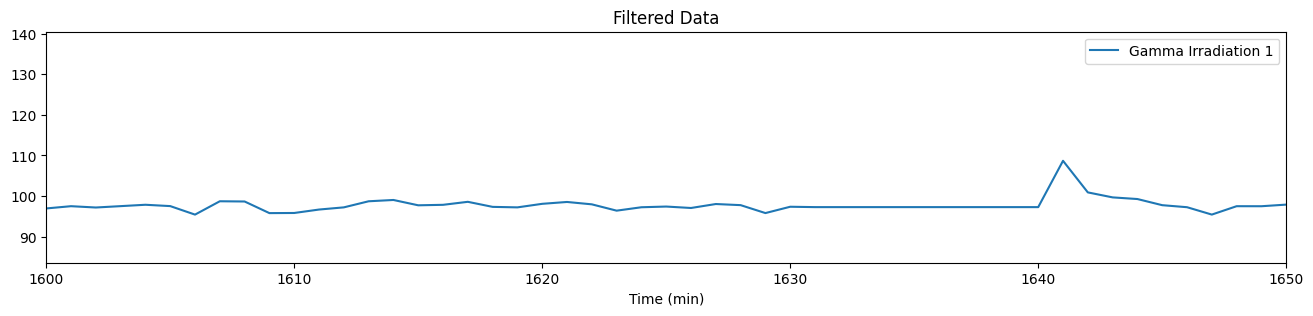

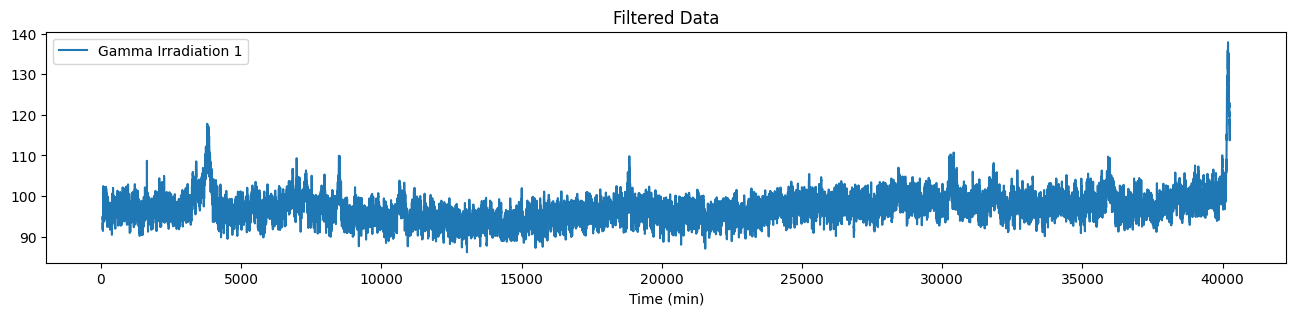

In [8]:


# Remove the first and last hour of data
Nh = 60  # 1 hour
t_trimmed = t[Nh:N-Nh]

# Plot the data
plt.figure(figsize=(16, 3))
plt.title('Filtered Data')
plt.plot(t_trimmed, filtered_data.iloc[:, 0][Nh:N-Nh], label=f'Gamma Irradiation 1')
plt.legend()
plt.xlabel('Time (min)')
plt.xlim(1600,1650)
plt.show()

plt.figure(figsize=(16, 3))
plt.title('Filtered Data')
plt.plot(t_trimmed, filtered_data.iloc[:, 0][Nh:N-Nh], label=f'Gamma Irradiation 1')
plt.legend()
plt.xlabel('Time (min)')
plt.show()

## SDT method to detect collectif motifs

In [9]:
def compute_moving_mean(signal, window_size):
    return signal.rolling(window=window_size, min_periods=1, center=True).mean()

def compute_moving_std(signal, window_size):
    return signal.rolling(window=window_size, min_periods=1, center=True).std()


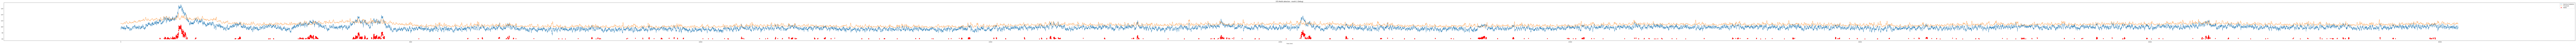

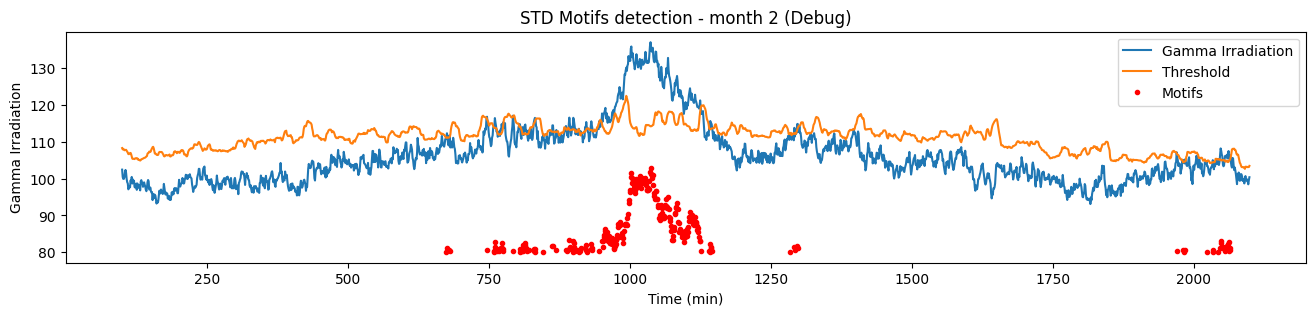

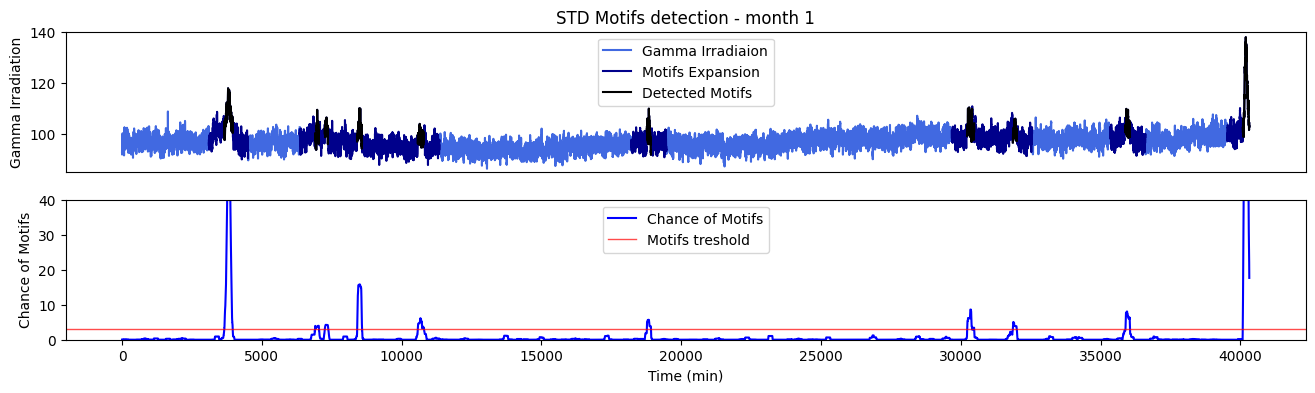

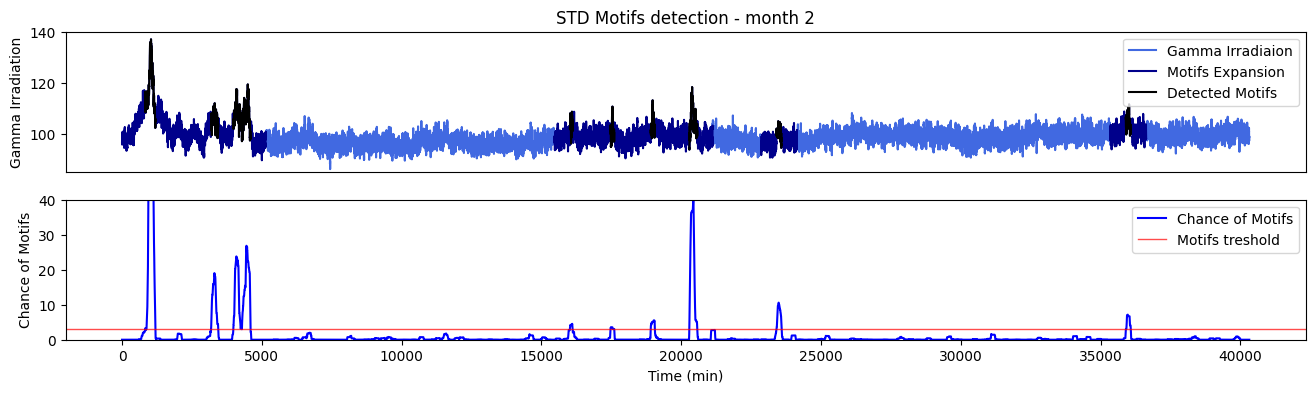

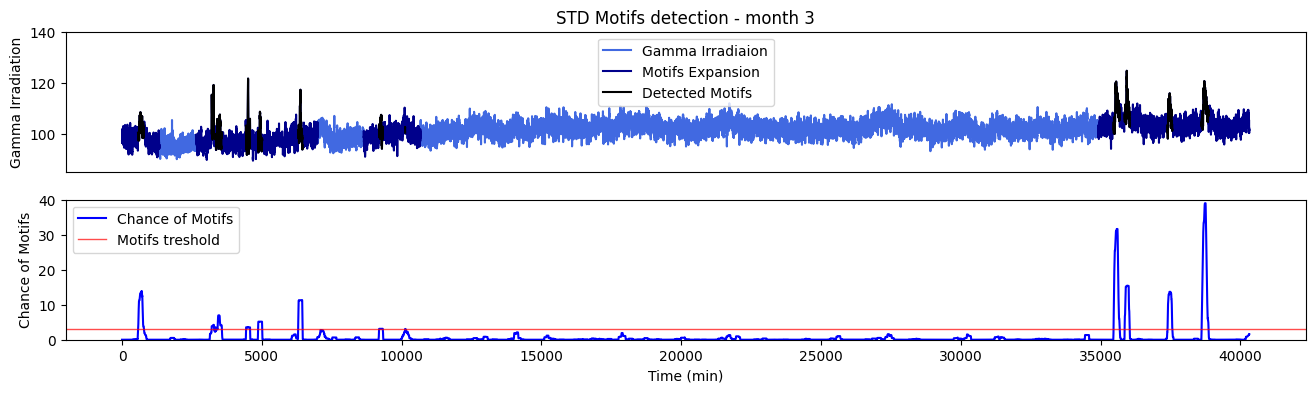

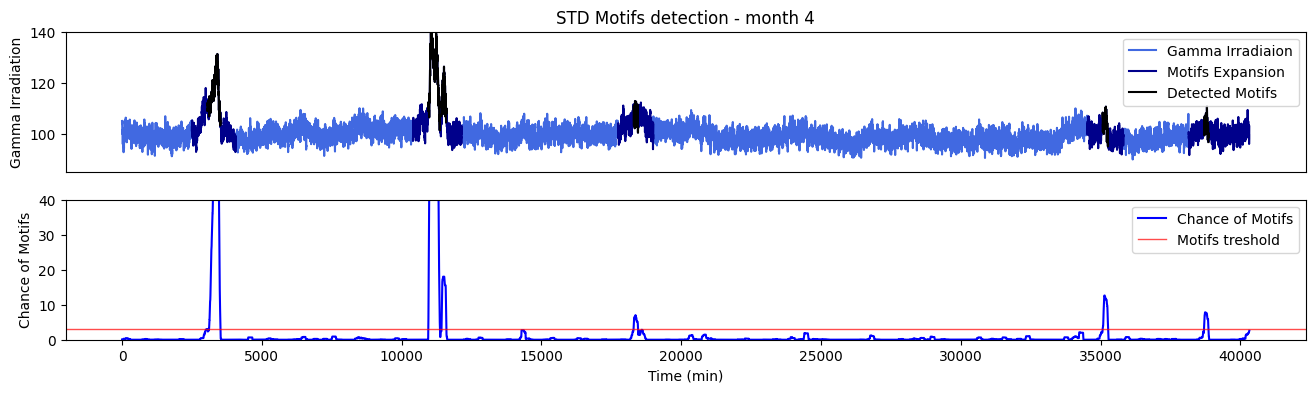

In [10]:
import numpy as np
signal = filtered_data.iloc[:, :]  # Select the signal points
time = t  # Select the time points

lw = 20  # Window length for moving standard deviation (75)
n = 70  # Window length multiplyer for moving mean

# Step 1: Compute the moving mean with window size n*lw
moving_mean = compute_moving_mean(signal, window_size=n*lw)

# Step 2: Compute the moving standard deviation with window size lw
moving_std = compute_moving_std(signal, window_size=lw)

# Step 3: Compute the threshold as moving_mean + 3 * moving_std
threshold = moving_mean + 3 * moving_std

# Step 4: Find points in the signal that exceed the threshold
dif = signal - threshold
dif[dif < 0] = 0

# Step 5: Motifs detection
coef = 10 # Multiplicative factor for the visualization of the dif_mean
dif_mean = compute_moving_mean(dif, 150)*coef # Moving mean of dif
th = 0.3*coef # Threshold of dif_mean to consider as motifs
detection = dif_mean > th # Motifs detection

# Step 6: Dilatation of the detected motifs
dilatation_window = np.ones(shape=(1100,1))  # A window will dilate 'True' values to neighboring points
expanded_window = np.ones(shape=(1000,1))  # A window will dilate 'True' values to neighboring points
expanded_detection = binary_dilation(detection, structure=dilatation_window)# Apply binary dilation
closed_detection = binary_closing(expanded_detection, structure=expanded_window, border_value=True)# Apply binary dilation

# Step 7: Motifs Extraction
motifs = signal[expanded_detection]
plotable_dif = dif[dif>0]
    
## Plot the data
# Zoom in plot
month = 2
plt.figure(figsize=(400, 6))
plt.plot(time, signal.iloc[:,month-1], label='Gamma Irradiation')
#plt.plot(time, moving_mean, label='Moving Mean')
plt.plot(time, threshold.iloc[:,month-1], label='Threshold')
#plt.plot(motifs, 'ro', label='Motifs')
plt.plot(80 + plotable_dif.iloc[:,month-1], 'ro', label='Motifs')
plt.xlabel('Time (min)')
plt.title(f'STD Motifs detection - month {month} (Debug)')
plt.legend()

plt.figure(figsize=(16, 3))
plt.plot(time[100:2100], signal.iloc[100:2100,month-1], label='Gamma Irradiation')
#plt.plot(time, moving_mean, label='Moving Mean')
plt.plot(time[100:2100], threshold.iloc[100:2100,month-1], label='Threshold')
#plt.plot(motifs, 'ro', label='Motifs')
plt.plot(80 + plotable_dif.iloc[100:2100,month-1], 'o', label='Motifs', color ='red', markersize=3)   
plt.xlabel('Time (min)')
plt.ylabel('Gamma Irradiation')
plt.title(f'STD Motifs detection - month {month} (Debug)')
plt.legend()

# Zoom out plot
for i in range(4):
    plt.figure(figsize=(16, 4))
    
    plt.subplot(2, 1, 1)
    plt.title(f'STD Motifs detection - month {i+1}')
    plt.plot(time, signal.mask(closed_detection).iloc[:,i], label='Gamma Irradiaion', color="royalblue")
    plt.plot(time, signal.mask(~closed_detection).iloc[:,i], label='Motifs Expansion', color="darkblue")
    plt.plot(time, signal[detection].iloc[:,i], label='Detected Motifs', color="black")
    plt.ylim(85, 140)
    plt.xticks([])
    plt.ylabel('Gamma Irradiation')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(time, dif_mean.iloc[:,i], label='Chance of Motifs', color="blue")
    plt.axhline(y=th, color='red', label='Motifs treshold', linestyle='-', linewidth=1, alpha=0.7)
    plt.ylim(0, 40)
    plt.xlabel('Time (min)')
    plt.ylabel('Chance of Motifs')
    plt.legend()
    
plt.show()


## Cutting Data


In [11]:
def false_sequence_extractor(signal, boolean_mask):
    # Find the indices where the value changes
    change_points = np.asarray(np.diff(boolean_mask.astype(int)) != 0).nonzero()[0] + 1
    
    # Add start and end points for completeness
    change_points = np.concatenate(([0], change_points, [len(boolean_mask)]))
    
    # Extract sequences of False values
    false_sequences = []
    for i in range(len(change_points) - 1):
        start, end = change_points[i], change_points[i + 1]
        if not boolean_mask[start]:
            false_sequences.append(signal[start:end])
    
    return false_sequences

In [42]:
normal_signals_df = pd.DataFrame(index=range(24237)) # 24237 is the length of the longest sequence

num = 0
for i in range(4):
    normal_sequences = false_sequence_extractor(signal.iloc[:, i], closed_detection[:, i])
    #print (f'Number of normal sequences in month {i+1}: {len(normal_sequences)}')
    for j, sequence in enumerate(normal_sequences):
        sequence.reset_index(drop=True, inplace=True)
        normal_signals_df[f'Normal {num}'] = sequence
        num += 1
        print(f'Normal {num} is from month {i+1} and has length {len(sequence)}')
        #print(f'   percentage of nan values: {sequence.isna().sum()/len(sequence)*100}%')


#save the normal sequences
normal_signals_df.to_json('Assets/Data/normal_sequences_df.json')




Normal 1 is from month 1 and has length 3105
Normal 2 is from month 1 and has length 1846
Normal 3 is from month 1 and has length 6869
Normal 4 is from month 1 and has length 10209
Normal 5 is from month 1 and has length 2790
Normal 6 is from month 1 and has length 2933
Normal 7 is from month 2 and has length 10323
Normal 8 is from month 2 and has length 1733
Normal 9 is from month 2 and has length 11208
Normal 10 is from month 2 and has length 3687
Normal 11 is from month 3 and has length 1316
Normal 12 is from month 3 and has length 1638
Normal 13 is from month 3 and has length 24237
Normal 14 is from month 4 and has length 2500
Normal 15 is from month 4 and has length 6338
Normal 16 is from month 4 and has length 5596
Normal 17 is from month 4 and has length 15517
Normal 18 is from month 4 and has length 2334


In [43]:
test2 = pd.read_json('Assets/Data/normal_sequences_df.json')
print(type(test2))
nan_percentage = test2.isna().mean() * 100
print(nan_percentage)
print(test2.shape)


<class 'pandas.core.frame.DataFrame'>
Normal 0     87.189009
Normal 1     92.383546
Normal 2     71.659034
Normal 3     57.878450
Normal 4     88.488674
Normal 5     87.898667
Normal 6     57.408095
Normal 7     92.849775
Normal 8     53.756653
Normal 9     84.787721
Normal 10    94.570285
Normal 11    93.241738
Normal 12     0.000000
Normal 13    89.685192
Normal 14    73.849899
Normal 15    76.911334
Normal 16    35.978050
Normal 17    90.370095
dtype: float64
(24237, 18)


# LSTMs